**Table of contents**<a id='toc0_'></a>    
- [함수 정의](#toc1_)    
- [Raw Parsing(텍스트, 이미지, 표)](#toc2_)    
- [병합](#toc3_)    
  - [불필요한 span 조합 텍스트 제거](#toc3_1_)    
    - [.......... 인덱스 텍스트 제거](#toc3_1_1_)    
    - [빈 표 제거](#toc3_1_2_)    
    - [Header 생성](#toc3_1_3_)    
    - [[임시] 첫페이지를 빼서 0번 Header 추가](#toc3_1_4_)    
    - [저장 안되는 문자 제거](#toc3_1_5_)    
    - [Block 별 병합 전 데이터 저장](#toc3_1_6_)    
- [Block 별 텍스트 병합](#toc4_)    
  - [PDF 내 같은 Block이었던 텍스트끼리 Line 병합](#toc4_1_)    
    - [기존 Line에 merge 후 중복 제거](#toc4_1_1_)    
    - [Index별로 document 분리](#toc4_1_2_)    
- [Doc 병합(H3 레벨)](#toc5_)    
  - [최소 h3 단위로 text 병합](#toc5_1_)    
  - [Doc 내 이미지 URL 마스킹](#toc5_2_)    
  - [Doc 내 테이블 URL 마스킹](#toc5_3_)    
  - [Doc 단위 병합](#toc5_4_)    
  - [Doc 단위 저장](#toc5_5_)    
  - [Doc 단위 저장](#toc5_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[함수 정의](#toc0_)

In [207]:
from IPython.display import display
import os
from PIL import Image
import math
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import fitz
from IPython.display import display
from IPython.display import Image as DisplayImage

import fitz  # Import PyMuPDF
from IPython.display import display  # Import display function
from PIL import Image, ImageDraw, ImageFont  # Import necessary classes from PIL
import io  # Import io module for converting bytes

from tqdm import tqdm
import re

In [208]:
dpi = 300
size_ratio = 1.3
y_range = (39, 575)

In [209]:
def draw_bbox(page, bboxs):

    for bbox in bboxs:  # iterate over all tables
        page.draw_rect(bbox,color=fitz.pdfcolor["blue"], width=1.5)
    pix = page.get_pixmap()  # Render page to an image

    # Convert the pixmap to a PIL Image
    img_bytes = pix.tobytes("png")  # Get the image bytes in PNG format
    img = Image.open(io.BytesIO(img_bytes))
    display(img)
    

In [210]:
def save_image(page, page_num, index, prev_text, bbox, xres, yres, width, height, ext, size_ratio=1.3, dpi=300):
    
    x_scale = dpi /xres  # PyMuPDF의 기본 해상도는 72 DPI입니다.
    y_scale = dpi / yres
    matrix = fitz.Matrix(x_scale, y_scale)  # 변환 행렬 생성
    
    # 선택한 bbox 영역의 이미지를 추출 (해상도 조절 적용)
    pix = page.get_pixmap(matrix=matrix, clip=bbox)
    
    # pix = page.get_pixmap(clip=bbox)
    
    # PIL 이미지로 변환
    image = Image.open(io.BytesIO(pix.tobytes()))
    image = image.resize((int(width*size_ratio), int(height*size_ratio)), Image.Resampling.LANCZOS)
    
    
    # 이미지에 텍스트 추가
    draw = ImageDraw.Draw(image)
    # 폰트는 시스템에 따라 경로가 다를 수 있으며, 필요에 따라 수정해야 할 수 있습니다.
    font = ImageFont.truetype("./font/NanumGothicBold.ttf", 16)  # 폰트와 크기 설정
    draw.text((10, 10), prev_text, fill='black', font=font)
    
    # image.save(f"./image/test.{b['ext']}", dpi=(b['xres'], b['yres']))
    img_url = f"./image/{NAMESPACE}/{page_num}_{index}_img.{ext}"
    image.save(img_url)
    return img_url
    
def save_table(page, page_num, index, prev_text, bbox, xres, yres, width, height, ext, size_ratio=1.3, dpi=300, text_rotation=False):
    if text_rotation:
        page.set_rotation(0)
    x_scale = dpi/2 /xres  # PyMuPDF의 기본 해상도는 72 DPI입니다.
    y_scale = dpi/2 / yres
    matrix = fitz.Matrix(x_scale, y_scale)  # 변환 행렬 생성
    
    # 선택한 bbox 영역의 이미지를 추출 (해상도 조절 적용)
    # pix = page.get_pixmap(matrix=matrix, clip=bbox)
    pix = page.get_pixmap(matrix=matrix, clip=bbox)
    
    # pix = page.get_pixmap(clip=bbox)
    
    # PIL 이미지로 변환
    image = Image.open(io.BytesIO(pix.tobytes()))
    # image = image.resize((int(width*size_ratio), int(height*size_ratio)), Image.Resampling.LANCZOS)
    
    
    # 이미지에 텍스트 추가
    draw = ImageDraw.Draw(image)
    # 폰트는 시스템에 따라 경로가 다를 수 있으며, 필요에 따라 수정해야 할 수 있습니다.
    font = ImageFont.truetype("./font/NanumGothicBold.ttf", 16)  # 폰트와 크기 설정
    draw.text((10, 10), prev_text, fill='black', font=font)
    
    # image.save(f"./image/test.{b['ext']}", dpi=(b['xres'], b['yres']))
    
    if text_rotation:
        image = image.rotate(270,expand=True)
        page.set_rotation(90)
    img_url = f"./image/{NAMESPACE}/{page_num}_{index}_table.{ext}"
    image.save(img_url)
    return img_url
        

In [220]:
def get_rotated_bbox(page, rect):
    """
    Adjust the bounding box coordinates for a page that is rotated 90 degrees clockwise.
    
    Args:
    - page: The page object from PyMuPDF.
    - rect: The original bounding box as a fitz.Rect object.
    
    Returns:
    - A fitz.Rect object representing the adjusted bounding box.
    """
    if page.rotation == 90:
        page_width = page.rect.width
        page_height = page.rect.height
        
        # Transform the rectangle coordinates
        new_x0 = rect.y0
        new_y0 = page_width - rect.x1
        new_x1 = rect.y1
        new_y1 = page_width - rect.x0
        
        # Create a new rectangle with the adjusted coordinates
        adjusted_rect = fitz.Rect(new_x0, new_y0, new_x1, new_y1)
        return adjusted_rect
    
    # If no rotation or a different rotation, return the original rectangle
    return rect

def is_text_rotated(page):
    blocks = page.get_text("dict")['blocks']
    if page.find_tables().tables:
        for b in blocks:
            if 'lines' in b:
                for line in b["lines"]:
                    if 'dir' in line:
                        if line['dir'] == (0.0, -1.0):
                            return True
    else:
        return False
    return False

def analyze_page_layout(page, text_rotate):
    tbls = page.find_tables().tables
    is_two_column = True
    blocks = page.get_text("dict")["blocks"]

    # 텍스트가 로테이트 되어있거나,
    if text_rotate:
        is_two_column = False
    # 테이블이 있는데 width가 페이지 넓이 절반보다 크거나,    
    tbls = page.find_tables().tables
    if tbls:
        for tbl in tbls:
            bbox = tbl.bbox
            if (bbox[2] - bbox[0]) > page.rect.width/2:
                is_two_column = False
    # Block 있는데 width가 페이지 넓이 절반보다 크거나.
    if len(list(filter(lambda x: (x['bbox'][2] - x['bbox'][0])>(page.rect.width/2), blocks)))>0:
        is_two_column = False
    return is_two_column
    
def sort_blocks(blocks, is_two_column, page_mid, page_rotation=False):
    blocks = [
        b for b in blocks 
        if b['bbox'][1] >= y_range[0] and b['bbox'][3] <= y_range[1]
    ]

    if is_two_column:
        left_blocks = [b for b in blocks if b['bbox'][0] < page_mid]
        right_blocks = [b for b in blocks if b['bbox'][0] >= page_mid]
        sorted_blocks = sorted(left_blocks, key=lambda b: (b['bbox'][1], b['bbox'][0])) + \
                        sorted(right_blocks, key=lambda b: (b['bbox'][1], b['bbox'][0]))
    else:
        if page_rotation:
            sorted_blocks = sorted(blocks, key=lambda b: (b['bbox'][0], b['bbox'][1]))
        else:
            sorted_blocks = sorted(blocks, key=lambda b: (b['bbox'][1], b['bbox'][0]))
    return sorted_blocks

def contains_image_name(text):
    # pattern = re.compile(r'^(?=.*[A-Z])(?=.*\d)[A-Z\d]+$')
    pattern = re.compile(r'^(?=.*[A-Z])(?=.*\d)[A-Z\d]+$')
    pattern2 = re.compile(r'^(?=.*[A-Z])(?=.*\d)+$')
    matched = (bool(pattern.match(text))) or (bool(pattern2.match(text)))
    return matched

def get_tbl_df(tbl, text_rotation=False):
    # 여기서 병합된 셀이 단순하다면 이전 cell ffill customizing 필요
    df = tbl
    df.columns = df.columns = [re.sub(r'^\d+-', '', col) for col in df.columns]
    null_sum = df.isnull().sum()
    null_cols = null_sum[null_sum == df.shape[0]].index
    df = df.drop(null_cols, axis=1)
    if text_rotation:
        
        first_col_as_df = pd.DataFrame([df.columns.tolist(), df.iloc[0,:].values], columns=range(0, len(df.columns)))
        
        empty_str_cols = np.where(first_col_as_df.iloc[1, :].values == '')[0].tolist()
        first_col_as_df.loc[0, empty_str_cols] = ''
        
        None_str_cols = np.where(first_col_as_df.iloc[1, :].values is None)[0].tolist()
        first_col_as_df.loc[0, None_str_cols] = None
        first_col_as_df = first_col_as_df.loc[[0],:]
        
        df.columns = range(0, len(df.columns))
        df = pd.concat([first_col_as_df, df]).fillna(method='ffill')
        df = df.set_index(df.columns[0])
        df = df.T
        df = df.iloc[:,list(range(len(df.columns)-1,-1, -1))]

    df_cols = df.columns.tolist()
    for i in range(1, len(df_cols)):
        if "Col" in df_cols[i]:
            df_cols[i] = df_cols[i-1]  # "COl"을 이전 인덱스의 값으로 대체합니다.
            
    df.columns = df_cols
    df = df.fillna('')
    df_csv = df.to_csv()
    img_index = df.applymap(lambda x: contains_image_name(x))
    
    df[img_index] = '이미지 참조'
    
    df_md = df.to_markdown()
    
    return df_md, df_csv
        

In [212]:
def is_overlapping(area1, area2):
    """
    두 영역이 겹치는지 확인하는 함수.
    area1, area2: (x0, y0, x1, y1) 형식의 영역
    """
    x0_1, y0_1, x1_1, y1_1 = area1
    x0_2, y0_2, x1_2, y1_2 = area2
    return not (x1_1 < x0_2 or x1_2 < x0_1 or y1_1 < y0_2 or y1_2 < y0_1)


In [222]:
def display_pages_with_bboxes_and_captions(page_num, display_pages_with_bboxes_and_captions=True):
    spans_list = []
    contents_list = []
    image_url_list = []
    contents_type = []
    block_list = []
    dpi = 300
    size_ratio = 1.3
    prev_text = ""    

    doc = fitz.open(FILE_NM)
    doc2 = fitz.open(FILE_NM)
    
    page = doc.load_page(page_num)
    draw_page = doc2.load_page(page_num)
    text_rotation = is_text_rotated(page)

    table_areas_on_page = {}
    tbls = []
    
    plumber_tbls = plumber_pdf.pages[page_num].extract_tables()
    pymu_tbls = page.find_tables().tables
    if len(pymu_tbls) != len(plumber_tbls):
        for i, tbl in enumerate(page.find_tables().tables):
            table_areas_on_page[i] = get_rotated_bbox(page, fitz.Rect(tbl.bbox))
            tbls.append(tbl.to_pandas())
    else:
        for i, mutbl, pltbl in zip(range(len(pymu_tbls)), pymu_tbls, plumber_tbls):
            if 'cid' in str(pltbl):
                continue
            table_areas_on_page[i] = get_rotated_bbox(page, fitz.Rect(mutbl.bbox))
            mutbl_columns = mutbl.header.names
            pltbl_columns = pltbl[0]
            
            if mutbl_columns != pltbl_columns:
                mutbl_df = mutbl.to_pandas()
                if len(mutbl_columns) == len(pltbl_columns):
                    pltbl_columns = ['Col' if x is None else x for x in pltbl[0]]
                    mutbl_df.columns = pltbl_columns
                    mutbl_df = mutbl_df.loc[1:].reset_index(drop=True)
            else:
                mutbl_df = mutbl.to_pandas()
            tbls.append(mutbl_df)

    if text_rotation:
        page.set_rotation(90)
        draw_page.set_rotation(90)
    is_two_column = analyze_page_layout(page, text_rotation)
    blocks = page.get_text("dict")["blocks"]  # Get text blocks
    blocks_sorted = sort_blocks(blocks, is_two_column, page.rect.width / 2, page.rotation)

    r_tbls = []
    for i, tbl in enumerate(page.find_tables().tables):
        r_tbls.append(tbl)

    prev_overlap_tbl_num=-1
    for i, b in enumerate(blocks_sorted):
        overlapping=False
        block_num = f"{page_num}_{i}"
        bbox = b['bbox']  # Get the bounding box of the block
        caption = str(i + 1)
        if b['type'] == 0:  # Block contains text
            # 테이블 bbox안의 텍스트 block이라면 PASS
            block_area = b['bbox']  # 텍스트 블록의 영역 (x0, y0, x1, y1)
            
            for tbl_num, table_area in table_areas_on_page.items():
                if is_overlapping(block_area, table_area):
                    overlapping=True
                    if tbl_num != prev_overlap_tbl_num:
                        # print("TODO: PANDAS EXTACT, SAVE IMAGE")
                        spans_list.append(None)
                        content, tbl_csv = get_tbl_df(tbls[tbl_num], text_rotation)
                        contents_list.append(content)
                        # Save Table Image
                        rect = fitz.Rect(r_tbls[tbl_num].bbox)
                        tab_bbox = get_rotated_bbox(page, rect)
                        # draw_page.draw_rect(tab_bbox,color=fitz.pdfcolor["blue"], width=1.5)
                        
                        img_url = save_table(draw_page, page_num, tbl_num, '', tab_bbox, 99, 99, tab_bbox[3]-tab_bbox[1], tab_bbox[2] - tab_bbox[0], 
                                   'jpeg', size_ratio=1.3, dpi=300, text_rotation=text_rotation)

                        
                        image_url_list.append(img_url)
                        block_list.append(block_num)
                        contents_type.append('table')
                        prev_overlap_tbl_num = tbl_num
                        break
                    else:
                        # print("테이블 추출 이미 완료")
                        break
        
                    
            if overlapping:
                continue

            # TODO: INSERT ROW BY LINES
            
            if 'lines' in b:
                for line in b['lines']:
                    line_text = ''.join(list(map(lambda x: x.get('text', ''), line['spans'])))
                
                    line_spans = str(set(list(map(lambda x: str((x.get('font'), x.get('color'), int(x.get('size')))), 
                                                  line['spans'])))).replace('{', '').replace('}', '')                    

                    spans_list.append(line_spans)
                    contents_list.append(line_text)
                    image_url_list.append(None)
                    contents_type.append('text')
                    block_list.append(block_num)
            
                
            # Insert text on the pixmap
              # Reading order number as caption
            rect = fitz.Rect(bbox)  # Create a rectangle
            
            draw_page.insert_text(  # insert footer 50 points above page bottom
                    (bbox[0], bbox[1]), caption, color=(1,0,0)
                )

            #이미지 캡션을 위해 한줄짜리 block인지 확인 후 저장
            text_lines = [span['text'] for line in b["lines"] for span in line["spans"]]
            text_lines = list(filter(lambda x: (x != '̰') and (x != ' ') and (x != '•'),text_lines))
            if len(text_lines) == 1:
                
                spans = b["lines"][0]["spans"][0]
                if not ((spans['size']==6) and (spans['font']=='HyundaiSansTextKR') and 
                        (spans['color']==16777215)):
                    prev_text = text_lines[0]
        if b['type'] != 0:  # Block contains text
            block_area = b['bbox']
            for tbl_num, table_area in table_areas_on_page.items():
                if is_overlapping(block_area, table_area):
                    overlapping=True
                    break
            if overlapping:
                continue
            else:
                # Save Images
                xres = b['xres']  # PyMuPDF의 기본 해상도는 72 DPI입니다.
                yres = b['yres']
                ext = b['ext']
                width = b['width']
                height = b['height']
                
                img_url = save_image(draw_page, page_num, i, prev_text, bbox, xres, yres, width, height, ext, size_ratio=1.3, dpi=300)
                spans_list.append(None)
                contents_list.append(None)
                image_url_list.append(img_url)
                contents_type.append('image')
                block_list.append(block_num)
                prev_text = ""  # 이전 텍스트 초기화
                
    pix = draw_page.get_pixmap()  # Render page to an image

    # Convert the pixmap to a PIL Image
    img_bytes = pix.tobytes("png")  # Get the image bytes in PNG format
    img = Image.open(io.BytesIO(img_bytes))

    # Display the image in the notebook
    if display_pages_with_bboxes_and_captions:
        display(img)
    # return blocks_sorted
    return {'span': spans_list, 'contents': contents_list, 'img_urls': image_url_list, 'contents_type': contents_type, 'block_num': block_list}

In [223]:
import pdfplumber

In [224]:
# FILE_NM = "2023 더 뉴 아반떼 - 정기점검.pdf"#"2024 아이오닉 5 (IONIQ 5) NE.pdf"
FILE_NM = "./pdf/2024 아이오닉 5 (IONIQ 5) NE.pdf"

# NAMESPACE = 'the_new_avante_2023'#'ioniq5_2024'
NAMESPACE = 'ioniq5_2024'

doc = fitz.open(FILE_NM)
plumber_pdf = pdfplumber.open(FILE_NM)
os.makedirs(f'./image/{NAMESPACE}', exist_ok=True)

doc_start =6
doc_end = 593

# <a id='toc2_'></a>[Raw Parsing(텍스트, 이미지, 표)](#toc0_)

In [225]:
span_list = []
contents_list = []
img_urls = []
contents_type = []
block_nums = []

for page_num in tqdm(range(doc_start, doc_end)): 
    v = display_pages_with_bboxes_and_captions(page_num, display_pages_with_bboxes_and_captions=False)
    span_list.extend(v['span'])
    contents_list.extend(v['contents'])
    img_urls.extend(v['img_urls'])
    contents_type.extend(v['contents_type'])
    block_nums.extend(v['block_num'])

100%|██████████| 587/587 [04:54<00:00,  1.99it/s]


In [226]:

ioniq_df = pd.DataFrame({
    'span': span_list,
    'contents': contents_list,
    'img_urls': img_urls,
    'ctype': contents_type,
    'block_num': block_nums
})

In [227]:
ioniq_df.to_csv('./parse_result/raw_ioniq5_result.csv', index=False)
ioniq_df.to_parquet('./parse_result/raw_ioniq5_result.parquet', index=False)

# <a id='toc3_'></a>[병합](#toc0_)

In [228]:
ioniq_df = pd.read_parquet('./parse_result/raw_ioniq5_result.parquet')
ioniq_df = ioniq_df[~ioniq_df['contents'].isna()].copy()

## <a id='toc3_1_'></a>[불필요한 span 조합 텍스트 제거](#toc0_)
- 제조사별 일반화 가능할까?

In [229]:
def contains_alpha_numeric(text):
    text = re.sub(r'\d+', '', text)
    return bool(re.search('[가-힣a-zA-Z0-9]', text))

def contains_korean(text):
    return bool(re.search('[가-힣]', text))
    
def contains_numeric(text):
    return bool(re.match(r'^[0-9!@#$%^&*()\-_=+[\]{};:\'",.<>?`~\\|/]*$', text))
    
def contains_image_name(text):
    # pattern = re.compile(r'^(?=.*[A-Z])(?=.*\d)[A-Z\d]+$')
    pattern = re.compile(r'^[A-Z\d-]+$')

    return bool(pattern.match(text))


In [230]:
ioniq_df['alphanumeric'] = ioniq_df['contents'].apply(lambda x: contains_alpha_numeric(x))
ioniq_df['korean'] = ioniq_df['contents'].apply(lambda x: contains_korean(x))
ioniq_df['numeric'] = ioniq_df['contents'].apply(lambda x: contains_numeric(x))
ioniq_df['image_name'] = ioniq_df['contents'].apply(lambda x: contains_image_name(x))

In [231]:
ioniq_df = ioniq_df[ioniq_df['alphanumeric']]
ioniq_df = ioniq_df[~ioniq_df['contents'].str.contains(r'\.\.\.')]
ioniq_df = ioniq_df[~ioniq_df['numeric']]
ioniq_df = ioniq_df[~ioniq_df['image_name']]
# ioniq_df = ioniq_df[~ioniq_df['image_name2']]

- 삭제 Span
    - "('HyundaiSansHeadKR', 0, 14)"
    - "('HyundaiSansHeadKR', 13416, 25)"	
    - "('HyundaiSansTextKR', 16777215, 6)"

- Heading 1
    - "('HyundaiSansHeadKR', 13416, 28)"

- Heading 2
    - "('HyundaiSansTextKRMedium', 13416, 14)"

- Heading 3
    - "('HyundaiSansTextKRMedium', 13416, 12)"	

- Heading 4
    - "('HyundaiSansTextKRMedium', 0, 10)"

In [232]:
ioniq_df = ioniq_df[~(ioniq_df['span']=='"(\'HyundaiSansHeadKR\', 0, 14)"')]  # 마, 카, 타
ioniq_df = ioniq_df[~(ioniq_df['span']=='"(\'HyundaiSansHeadKR\', 13416, 25)"')]  # 색인
ioniq_df = ioniq_df[~(ioniq_df['span']=='"(\'HyundaiSansTextKR\', 16777215, 6)"')]  # 불필요 영어

In [233]:
gdf = ioniq_df.groupby('span')

In [234]:
delete_spans = [] 
for key, cur_gdf in gdf:
    print(key)
    display(cur_gdf.head(2))
    is_contain_text = contains_alpha_numeric(''.join(cur_gdf.head(2)['contents'].values))
    if not is_contain_text:
        delete_spans.append(key)
    print(is_contain_text)

"('HyundaiSansHeadKR', 0, 10)", "('HyundaiSansHeadKR', 0, 9)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
2384,"""('HyundaiSansHeadKR', 0, 10)"", ""('HyundaiSans...",• 브레이크 오일 점검,None,text,79_3,True,True,False,False
2391,"""('HyundaiSansHeadKR', 0, 10)"", ""('HyundaiSans...",• 냉각수 누수 점검,None,text,79_4,True,True,False,False


True
"('HyundaiSansHeadKR', 0, 10)", "('HyundaiSansTextKR', 0, 9)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
84,"""('HyundaiSansHeadKR', 0, 10)"", ""('HyundaiSans...",• 본 차량의 배터리는 모터 및 에어컨을 작동,None,text,8_8,True,True,False,False
88,"""('HyundaiSansHeadKR', 0, 10)"", ""('HyundaiSans...",• 보조 배터리는 주행 가능 표시등(,None,text,8_8,True,True,False,False


True
"('HyundaiSansHeadKR', 0, 10)", "('HyundaiSansTextKR', 0, 9)", "('HyundaiSansHeadKR', 0, 9)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
93,"""('HyundaiSansHeadKR', 0, 10)"", ""('HyundaiSans...",• 구동용(고전압) 배터리 충전장치(OBC): 전,None,text,8_10,True,True,False,False
96,"""('HyundaiSansHeadKR', 0, 10)"", ""('HyundaiSans...",• 인버터: 직류 > 교류 변환하여 모터에 전원,None,text,8_10,True,True,False,False


True
"('HyundaiSansHeadKR', 0, 9)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
213,"""('HyundaiSansHeadKR', 0, 9)""",자세한 내용은 5장 ‘솔라루프’를 참고하십시오.,None,text,11_4,True,True,False,False
847,"""('HyundaiSansHeadKR', 0, 9)""",충전기의 형상 및 사용 방법은 각 충전기 제조,None,text,28_9,True,True,False,False


True
"('HyundaiSansHeadKR', 13416, 28)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
0,"""('HyundaiSansHeadKR', 13416, 28)""",0. 전기차 시작하기,None,text,6_0,True,True,False,False
2153,"""('HyundaiSansHeadKR', 13416, 28)""",1. 안내 및 차량 정보,None,text,62_0,True,True,False,False


True
"('HyundaiSansTextKR', 0, 7)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
838,"""('HyundaiSansTextKR', 0, 7)""",완속 충전기,None,text,28_1,True,True,False,False
841,"""('HyundaiSansTextKR', 0, 7)""",완속 충전 케이블,None,text,28_4,True,True,False,False


True
"('HyundaiSansTextKR', 0, 7)", "('HyundaiSansTextKR', 4342338, 4)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
4778,"""('HyundaiSansTextKR', 0, 7)"", ""('HyundaiSansT...",*1:: 승객 구분 시스템은 성인의 체격 조건에 해당하는 사람을 성인으로 판단합니다...,None,text,134_8,True,True,False,False
4780,"""('HyundaiSansTextKR', 0, 7)"", ""('HyundaiSansT...",*2:: 어린이를 동승석에 앉히지 마십시오. 성체격이 큰 어린이가 동승석에 앉으면 ...,None,text,134_9,True,True,False,False


True
"('HyundaiSansTextKR', 0, 8)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
2105,"""('HyundaiSansTextKR', 0, 8)""",[A] 돌리,None,text,59_7,True,True,False,False
3255,"""('HyundaiSansTextKR', 0, 8)""",[A] 동시동작,None,text,99_12,True,True,False,False


True
"('HyundaiSansTextKR', 0, 8)", "('HyundaiSansHeadKR', 0, 10)", "('HyundaiSansTextKR', 0, 9)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
6429,"""('HyundaiSansTextKR', 0, 8)"", ""('HyundaiSansH...",• 인포테인먼트 시스템에서 설정 > 차량 > 편,None,text,179_13,True,True,False,False
6485,"""('HyundaiSansTextKR', 0, 8)"", ""('HyundaiSansH...",• 인포테인먼트 시스템에서 설정 > 차량 > 편,None,text,180_10,True,True,False,False


True
"('HyundaiSansTextKR', 0, 8)", "('HyundaiSansTextKR', 0, 9)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
210,"""('HyundaiSansTextKR', 0, 8)"", ""('HyundaiSansT...",화면에서 ‘솔라 루프 정보’를 선택하면 솔라 루,None,text,11_4,True,True,False,False
249,"""('HyundaiSansTextKR', 0, 8)"", ""('HyundaiSansT...",화면에서 ‘예약 충전 및 공조’를 선택하십시오.,None,text,12_11,True,True,False,False


True
"('HyundaiSansTextKR', 0, 8)", "('HyundaiSansTextKR', 0, 9)", "('HyundaiSansHeadKR', 0, 9)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
9828,"""('HyundaiSansTextKR', 0, 8)"", ""('HyundaiSansT...",게)를 선택하십시오(기본 설정: 빠르게).,None,text,249_9,True,True,False,False


True
"('HyundaiSansTextKR', 0, 9)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
53,"""('HyundaiSansTextKR', 0, 9)""",전기 자동차는 배터리와 전기 모터로 구동되는,None,text,8_1,True,True,False,False
54,"""('HyundaiSansTextKR', 0, 9)""",자동차입니다. 일반 자동차는 내연기관을 이용,None,text,8_1,True,True,False,False


True
"('HyundaiSansTextKR', 0, 9)", "('HyundaiSansHeadKR', 0, 9)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
597,"""('HyundaiSansTextKR', 0, 9)"", ""('HyundaiSansH...",급속 충전 성능 유지를 위해 배터리 컨디셔,None,text,20_2,True,True,False,False
2962,"""('HyundaiSansTextKR', 0, 9)"", ""('HyundaiSansH...",- 운전석 공조 연동 자동 제어: 히터 및 에어컨 시스템과 연동하여 스티어링 휠 열...,None,text,93_3,True,True,False,False


True
"('HyundaiSansTextKR', 6908265, 9)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
310,"""('HyundaiSansTextKR', 6908265, 9)""",실외,None,text,14_12,True,True,False,False
359,"""('HyundaiSansTextKR', 6908265, 9)""",실내,None,text,15_4,True,True,False,False


True
"('HyundaiSansTextKRMedium', 0, 10)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
238,"""('HyundaiSansTextKRMedium', 0, 10)""",출발 일정 설정,None,text,12_3,True,True,False,False
262,"""('HyundaiSansTextKRMedium', 0, 10)""",예약 충전 할인 시간 설정,None,text,13_0,True,True,False,False


True
"('HyundaiSansTextKRMedium', 13416, 12)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
60,"""('HyundaiSansTextKRMedium', 13416, 12)""",전기 자동차 특징,None,text,8_2,True,True,False,False
83,"""('HyundaiSansTextKRMedium', 13416, 12)""",배터리에 대한 정보,None,text,8_7,True,True,False,False


True
"('HyundaiSansTextKRMedium', 13416, 14)"


,span,contents,img_urls,ctype,block_num,alphanumeric,korean,numeric,image_name
52,"""('HyundaiSansTextKRMedium', 13416, 14)""",전기 자동차 개요,None,text,8_0,True,True,False,False
132,"""('HyundaiSansTextKRMedium', 13416, 14)""",구동용(고전압) 배터리,None,text,9_0,True,True,False,False


True


### <a id='toc3_1_3_'></a>[Header 생성](#toc0_)

In [235]:
ioniq_df['index'] = None

In [236]:
h1_span = '"(\'HyundaiSansHeadKR\', 13416, 28)"'
ioniq_df.loc[ioniq_df['span']==h1_span, 'index'] = 'h1'

In [237]:
h2_span = '"(\'HyundaiSansTextKRMedium\', 13416, 14)"'
ioniq_df.loc[ioniq_df['span']==h2_span, 'index'] = 'h2'

In [238]:
h3_span = '"(\'HyundaiSansTextKRMedium\', 13416, 12)"'
ioniq_df.loc[ioniq_df['span']==h3_span, 'index'] = 'h3'

In [239]:
h4_span = '"(\'HyundaiSansTextKRMedium\', 0, 10)"'
ioniq_df.loc[ioniq_df['span']==h4_span, 'index'] = 'h4'

### <a id='toc3_1_5_'></a>[저장 안되는 문자 제거](#toc0_)

In [240]:
ioniq_df['contents'] = ioniq_df['contents'].str.replace('\u2022', '') # 불릿


### <a id='toc3_1_6_'></a>[Block 별 병합 전 데이터 저장](#toc0_)

In [241]:
ioniq_df.to_csv('./parse_result/line_ioniq5_result.csv', index=False)
ioniq_df.to_parquet('./parse_result/line_ioniq5_result.parquet', index=False)

# <a id='toc4_'></a>[Block 별 텍스트 병합](#toc0_)

In [242]:
ioniq_df = pd.read_parquet('./parse_result/line_ioniq5_result.parquet')

## <a id='toc4_1_'></a>[PDF 내 같은 Block이었던 텍스트끼리 Line 병합](#toc0_)

In [243]:
merge_contents = pd.DataFrame(ioniq_df[~ioniq_df['contents'].isnull()].groupby(['block_num'])['contents'].apply(lambda x: ''.join(x))).reset_index()
merge_contents.columns = ['block_num', 'merge_contents']

### <a id='toc4_1_1_'></a>[기존 Line에 merge 후 중복 제거](#toc0_)

In [244]:
ioniq_df = ioniq_df.merge(merge_contents, on=['block_num'], how='left')
m_ioniq_df = ioniq_df.drop_duplicates('block_num', keep='first').reset_index(drop=True).drop('contents', axis=1)

### <a id='toc4_1_2_'></a>[Index별로 document 분리](#toc0_)

**Header level, Header 내용이 달라질때 마다 document grouping**
- Header: h1, h2, h3, h4


In [245]:
m_ioniq_df['doc_group'] = (~m_ioniq_df['index'].isnull()).cumsum()

In [246]:
m_ioniq_df['h1'] = None
m_ioniq_df['h2'] = None
m_ioniq_df['h3'] = None

In [247]:
m_ioniq_df.loc[m_ioniq_df['index']=='h1', 'h1'] = m_ioniq_df.loc[m_ioniq_df['index']=='h1', 'merge_contents']
m_ioniq_df.loc[m_ioniq_df['index']=='h2', 'h2'] = m_ioniq_df.loc[m_ioniq_df['index']=='h2', 'merge_contents']
m_ioniq_df.loc[m_ioniq_df['index']=='h3', 'h3'] = m_ioniq_df.loc[m_ioniq_df['index']=='h3', 'merge_contents']

- h1이 있는데 h2가 없으면 h2는 empty: h1 바로 밑에 text가 있는 경우
- h2가 있는데 h3가 없으면 h3는 empty: h2 바로 밑에 text가 있는 경우

In [248]:
m_ioniq_df.loc[(~m_ioniq_df['h1'].isna()) & (m_ioniq_df['h2'].isna()), 'h2'] = ''
m_ioniq_df.loc[(~m_ioniq_df['h2'].isna()) & (m_ioniq_df['h3'].isna()), 'h3'] = ''

In [249]:
m_ioniq_df[['h1', 'h2', 'h3']] = m_ioniq_df[['h1', 'h2', 'h3']].fillna(method='ffill')

In [250]:
m_ioniq_df.to_csv('./parse_result/block_ioniq5_result.csv', index=False)
m_ioniq_df.to_parquet('./parse_result/block_ioniq5_result.parquet', index=False)

# <a id='toc5_'></a>[Doc 병합(H3 레벨)](#toc0_)

In [251]:
m_ioniq_df = pd.read_parquet('./parse_result/block_ioniq5_result.parquet')

## <a id='toc5_1_'></a>[최소 h3 단위로 text 병합](#toc0_)

In [252]:
doc_merge_contents = m_ioniq_df[m_ioniq_df['ctype']=='text'].groupby('doc_group')['merge_contents'].apply(lambda x: '\n'.join(x)).reset_index()
doc_merge_contents.columns = ['doc_group', 'doc_contents']

In [253]:
doc_ioniq_df = m_ioniq_df[m_ioniq_df['ctype']=='text'].merge(doc_merge_contents, on='doc_group', how='left').drop_duplicates('doc_group', keep='first')

## <a id='toc5_2_'></a>[Doc 내 이미지 URL 마스킹](#toc0_)

In [254]:
doc_images = m_ioniq_df[m_ioniq_df['ctype']=='image']
doc_images = doc_images.groupby('doc_group')['img_urls'].apply(lambda x: list(x)).reset_index()

## <a id='toc5_3_'></a>[Doc 내 테이블 URL 마스킹](#toc0_)

In [255]:
doc_tables = m_ioniq_df[m_ioniq_df['ctype']=='table']
doc_tables = doc_tables[doc_tables['merge_contents'] != ''].copy()

doc_table_images = doc_tables.groupby('doc_group')['img_urls'].apply(lambda x: list(x)).reset_index()
# doc_tables['merge_contents'] = '표: ' + doc_tables['block_num'] + '\n' + doc_tables['merge_contents'] + '\n' 
doc_tables = doc_tables[['doc_group', 'merge_contents']].merge(doc_table_images, on='doc_group', how='outer')
doc_tables.columns = ['doc_group', 'table_contents', 'table_img_urls']

## <a id='toc5_4_'></a>[Doc 단위 병합](#toc0_)

In [256]:
final_doc_df = doc_ioniq_df.drop(['img_urls', 'merge_contents'], axis=1).merge(doc_images, on='doc_group', how='left')\
    .merge(doc_tables, on='doc_group', how='left')
# final_doc_df['doc_table_contents'] = ''

In [257]:
final_doc_df = final_doc_df[final_doc_df['h1']!=final_doc_df['doc_contents']]
final_doc_df = final_doc_df[final_doc_df['h2']!=final_doc_df['doc_contents']]
final_doc_df = final_doc_df[final_doc_df['h3']!=final_doc_df['doc_contents']]

In [258]:
final_doc_df[['doc_contents']] = final_doc_df[['doc_contents']].fillna('')
final_doc_df['table_contents'] = final_doc_df['table_contents'].apply(lambda d: d if np.array(d) is not np.nan else None)
final_doc_df['img_urls'] = final_doc_df['img_urls'].apply(lambda d: d if np.array(d) is not np.nan else None)
final_doc_df['table_img_urls'] = final_doc_df['table_img_urls'].apply(lambda d: d if np.array(d) is not np.nan else None)


In [259]:
final_doc_df = final_doc_df.reset_index(drop=True)

## <a id='toc5_5_'></a>[Doc 단위 저장](#toc0_)

In [260]:
final_doc_df

,span,ctype,block_num,alphanumeric,korean,numeric,image_name,index,doc_group,h1,h2,h3,doc_contents,img_urls,table_contents,table_img_urls
0,"""('HyundaiSansTextKRMedium', 13416, 14)""",text,8_0,True,True,False,False,h2,2,0. 전기차 시작하기,전기 자동차 개요,,전기 자동차 개요\n전기 자동차는 배터리와 전기 모터로 구동되는자동차입니다. 일반 ...,NaN,NaN,NaN
1,"""('HyundaiSansTextKRMedium', 13416, 12)""",text,8_2,True,True,False,False,h3,3,0. 전기차 시작하기,전기 자동차 개요,전기 자동차 특징,전기 자동차 특징\n1. 구동용(고전압) 배터리에 충전된 전기를 이용하여 주행하기 ...,NaN,NaN,NaN
2,"""('HyundaiSansTextKRMedium', 13416, 12)""",text,8_7,True,True,False,False,h3,4,0. 전기차 시작하기,전기 자동차 개요,배터리에 대한 정보,배터리에 대한 정보\n 본 차량의 배터리는 모터 및 에어컨을 작동시키는 구동용(고전...,NaN,NaN,NaN
3,"""('HyundaiSansTextKRMedium', 13416, 12)""",text,8_9,True,True,False,False,h3,5,0. 전기차 시작하기,전기 자동차 개요,전기 자동차의 주요 장치,전기 자동차의 주요 장치\n 구동용(고전압) 배터리 충전장치(OBC): 전력망의 A...,NaN,NaN,NaN
4,"""('HyundaiSansTextKRMedium', 13416, 12)""",text,9_1,True,True,False,False,h3,7,0. 전기차 시작하기,구동용(고전압) 배터리,구동용(고전압) 배터리 (리튬 이온 배터리),구동용(고전압) 배터리 (리튬 이온 배터리)\n 차량을 주행하지 않아도 구동용(고전...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,"""('HyundaiSansTextKRMedium', 0, 10)""",text,591_2,True,True,False,False,h4,1097,9. 정기 점검,차체 손질,내장 손질,가죽 시트 관리 진공청소기를 사용하여 주기적으로 시트 표면에 있는 먼지와 모래를 제...,NaN,NaN,NaN
955,"""('HyundaiSansTextKRMedium', 0, 10)""",text,591_3,True,True,False,False,h4,1098,9. 정기 점검,차체 손질,내장 손질,가죽 시트 청소 방법 오염 물질은 즉시 제거해야 합니다. 오염 물질별 제거 방법은 ...,NaN,NaN,NaN
956,"""('HyundaiSansTextKRMedium', 0, 10)""",text,592_0,True,True,False,False,h4,1099,9. 정기 점검,차체 손질,내장 손질,"실내 장식품, 내장 트림과 카매트(카펫)의 청소 먼지 털이 빗자루나 진공 청소기로 ...",NaN,NaN,NaN
957,"""('HyundaiSansTextKRMedium', 0, 10)""",text,592_7,True,True,False,False,h4,1100,9. 정기 점검,차체 손질,내장 손질,안전벨트의 청소내장재 또는 카펫용으로 추천된 부드러운 비누액을 사용하여 안전벨트를 ...,NaN,NaN,NaN


## <a id='toc5_6_'></a>[Doc 단위 저장](#toc0_)

In [ ]:
final_doc_df.head()

,span,ctype,block_num,alphanumeric,korean,numeric,image_name,index,doc_group,h1,h2,h3,doc_contents,img_urls,table_contents,table_img_urls
0,"""('HyundaiSansTextKRMedium', 13416, 14)""",text,8_0,True,True,False,False,h2,2,0. 전기차 시작하기,전기 자동차 개요,,전기 자동차 개요\n전기 자동차는 배터리와 전기 모터로 구동되는자동차입니다. 일반 ...,NaN,NaN,NaN
1,"""('HyundaiSansTextKRMedium', 13416, 12)""",text,8_2,True,True,False,False,h3,3,0. 전기차 시작하기,전기 자동차 개요,전기 자동차 특징,전기 자동차 특징\n1. 구동용(고전압) 배터리에 충전된 전기를 이용하여 주행하기 ...,NaN,NaN,NaN
2,"""('HyundaiSansTextKRMedium', 13416, 12)""",text,8_7,True,True,False,False,h3,4,0. 전기차 시작하기,전기 자동차 개요,배터리에 대한 정보,배터리에 대한 정보\n 본 차량의 배터리는 모터 및 에어컨을 작동시키는 구동용(고전...,NaN,NaN,NaN
3,"""('HyundaiSansTextKRMedium', 13416, 12)""",text,8_9,True,True,False,False,h3,5,0. 전기차 시작하기,전기 자동차 개요,전기 자동차의 주요 장치,전기 자동차의 주요 장치\n 구동용(고전압) 배터리 충전장치(OBC): 전력망의 A...,NaN,NaN,NaN
4,"""('HyundaiSansTextKRMedium', 13416, 12)""",text,9_1,True,True,False,False,h3,7,0. 전기차 시작하기,구동용(고전압) 배터리,구동용(고전압) 배터리 (리튬 이온 배터리),구동용(고전압) 배터리 (리튬 이온 배터리)\n 차량을 주행하지 않아도 구동용(고전...,NaN,NaN,NaN


In [261]:
for tbl in final_doc_df.loc[~final_doc_df['table_contents'].isna(), ['block_num','table_contents']].values:
    print(tbl[0])
    print(tbl[1])
    print()

21_3
|    | 충전 방법   | 충전 방법   | 기본형                              | 항속형                              |
|---:|:------------|:------------|:------------------------------------|:------------------------------------|
|  0 | 완속 충전   |             | 상온에서 8시간 55분 소요            | 상온에서 11시간 45분 소요           |
|    |             |             | (100%까지 충전 가능)                | (100%까지 충전 가능)                |
|  1 | 급속 충전   | 350KW급     | 상온에서 18분 소요                  | 상온에서 18분 소요                  |
|    |             | 충전기      | (80%기준, 100%까지 충전 가능)       | (80%기준, 100%까지 충전 가능)       |
|  2 |             | 50KW급      | 상온에서 63분 소요                  | 상온에서 73분 소요                  |
|    |             | 충전기      | (80%기준, 100%까지 충전 가능)       | (80%기준, 100%까지 충전 가능)       |
|  3 | 휴대용 충전 |             | 상온에서 약 25시간 50분 이내로 소요 | 상온에서 약 34시간 25분 이내로 소요 |
|    |             |             | (100%까지 충전 가능)                | (100%까지 충전 가능)                |

22_0
|    | 구 분       | 완속 충전                 |

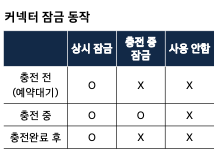
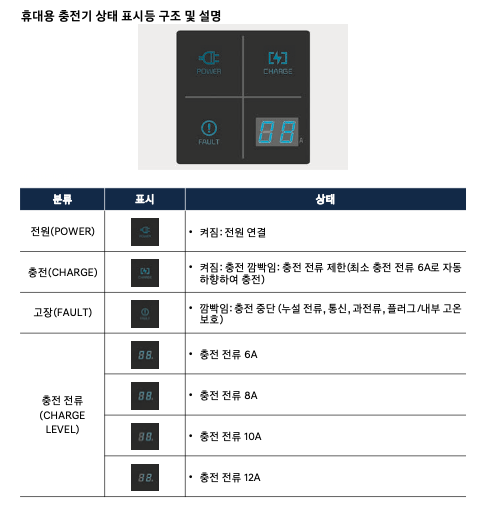
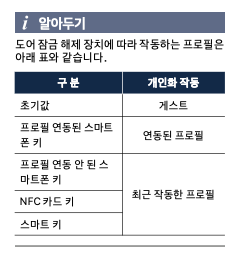
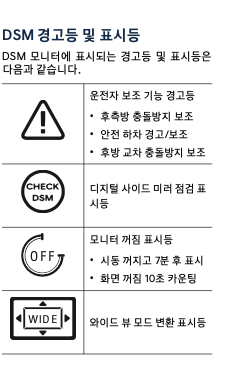
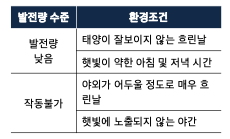
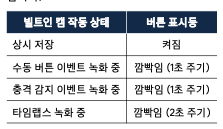

In [ ]:
final_doc_df.to_csv('./parse_result/doc_ioniq5_result.csv', encoding='cp949')
final_doc_df.to_parquet('./parse_result/doc_ioniq5_result.parquet')

# Table Parsing

import camelot


In [10]:
import camelot
import pdfplumber

In [11]:
doc = fitz.open(FILE_NM)
plumber_pdf = pdfplumber.open(FILE_NM)


In [12]:
page_num=21

In [158]:

tbl_sets = {}
mu_page = doc.load_page(page_num)
mu_tbls = mu_page.find_tables().tables
mu_tbls = list(filter(lambda x: not (x.to_pandas()=='').all().all(), mu_tbls))
if len(mu_tbls)>0:
    plumber_tbls = plumber_pdf.pages[page_num].extract_tables()
    plumber_tbls = list(filter(lambda x: not (np.array(x)=='').all().all(), plumber_tbls))
    if (len(mu_tbls)==1) and(len(plumber_tbls)==1) and ('cid' in str(plumber_tbls[0])):
        pass
    else:
        camelot_tbls = camelot.read_pdf(FILE_NM, pages=f"{page_num+1}",flavor='lattice', shift_text=['l', 't'], copy_text=['v','h'], strip_text=' .\n')
        camelot_tbls = list(filter(lambda x: not (x.df=='').all().all(), camelot_tbls))
        tbl_sets[page_num] = {
            'length': (len(mu_tbls), len(plumber_tbls), len(camelot_tbls)),
            'mu_tbls' : mu_tbls,
            'pl_tbls' : plumber_tbls,
            'ca_tbls' : camelot_tbls,
            'same_len' : bool(len(set((len(mu_tbls), len(plumber_tbls), len(camelot_tbls)))) == 1)
    }

In [160]:
tbl_sets

{512: {'length': (1, 1, 1),
  'mu_tbls': [<fitz.table.Table at 0x16fb18b80>],
  'pl_tbls': [[['작동 상태', '스마트 키 LED', '비상 경고등'],
    [None, '초록색 LED\n계속 깜빡임', None],
    [None, '빨간색 LED\n계속 깜빡임', None],
    [None, '빨간색 LED\n4초 켜진 후\n꺼짐', None],
    [None, '초록색 LED\n4초 켜진 후\n꺼짐', None]]],
  'ca_tbls': [<Table shape=(4, 3)>],
  'same_len': True}}

In [159]:
tbl_sets[512]['mu_tbls'][0].to_pandas()

,작동 상태,스마트 키 LED,비상 경고등
0,제어 중,초록색 LED\n계속 깜빡임,-
1,일시 중지,빨간색 LED\n계속 깜빡임,깜빡임
2,해제,빨간색 LED\n4초 켜진 후\n꺼짐,3회 깜빡인 후\n꺼짐
3,완료,초록색 LED\n4초 켜진 후\n꺼짐,1회 깜빡인 후\n꺼짐


In [157]:
(np.array(tbl_sets[512]['pl_tbls'][1])=='').all()

True

In [152]:
tbl_sets[512]['ca_tbls'][0].df

,0,1,2
0,제어중,초록색LED계속깜빡임,-
1,일시중지,빨간색LED계속깜빡임,깜빡임
2,해제,빨간색LED4초켜진후꺼짐,3회깜빡인후꺼짐
3,완료,초록색LED4초켜진후꺼짐,1회깜빡인후꺼짐


In [203]:
tbl_sets = {}
for page_num in tqdm(range(6,595)):
    mu_page = doc.load_page(page_num)
    mu_tbls = mu_page.find_tables().tables
    mu_tbls = list(filter(lambda x: not (x.to_pandas()=='').all().all(), mu_tbls))
    if len(mu_tbls)>0:
        plumber_tbls = plumber_pdf.pages[page_num].extract_tables()
        plumber_tbls = list(filter(lambda x: not (np.array(x)=='').all().all(), plumber_tbls))
        if (len(mu_tbls)==1) and(len(plumber_tbls)==1) and ('cid' in str(plumber_tbls[0])):
            pass
        else:
            camelot_tbls = camelot.read_pdf(FILE_NM, pages=f"{page_num+1}",flavor='lattice', shift_text=['l', 't'], copy_text=['v','h'], strip_text=' .\n')
            camelot_tbls = list(filter(lambda x: not (x.df=='').all().all(), camelot_tbls))
            tbl_sets[page_num] = {
                'length': (len(mu_tbls), len(plumber_tbls), len(camelot_tbls)),
                'mu_tbls' : list(map(lambda x: x.to_pandas(), mu_tbls)),
                'pl_tbls' : list(map(lambda x: x, plumber_tbls)),
                'ca_tbls' : list(map(lambda x: x.df, camelot_tbls)),
                'same_len' : bool(len(set((len(mu_tbls), len(plumber_tbls), len(camelot_tbls)))) == 1)
        }


100%|██████████| 589/589 [01:18<00:00,  7.46it/s]


In [199]:
mu_page = doc.load_page(43)
mu_tbls = mu_page.find_tables().tables
mu_tbls = list(filter(lambda x: not (x.to_pandas()=='').all().all(), mu_tbls))

In [174]:
same_len = 0
for k, v in tbl_sets.items():
    same_len += v['same_len']
same_len

30

In [180]:
same_len = 0
for k, v in tbl_sets.items():
    
    same_len += bool(len(v['mu_tbls']) == len(v['ca_tbls']))
same_len

34

In [198]:
v['mu_tbls'][0].to_pandas()

,속도 등급,최대 속도
0,,
1,,
2,,
3,,
4,,
5,,


In [204]:
for k, v in tbl_sets.items():
    if v['same_len']:
        if len(v['mu_tbls'])==1:
            print(k)
            for tbl in v['mu_tbls']:
                display(tbl)
            print('\n\n')
            for tbl in v['ca_tbls']:
                display(tbl)
            print('\n\n')

21


,충전 방법,Col1,기본형,항속형
0,완속 충전,None,상온에서 8시간 55분 소요\n(100%까지 충전 가능),상온에서 11시간 45분 소요\n(100%까지 충전 가능)
1,급속 충전,350KW급\n충전기,"상온에서 18분 소요\n(80%기준, 100%까지 충전 가능)","상온에서 18분 소요\n(80%기준, 100%까지 충전 가능)"
2,None,50KW급\n충전기,"상온에서 63분 소요\n(80%기준, 100%까지 충전 가능)","상온에서 73분 소요\n(80%기준, 100%까지 충전 가능)"
3,휴대용 충전,None,상온에서 약 25시간 50분 이내로 소요\n(100%까지 충전 가능),상온에서 약 34시간 25분 이내로 소요\n(100%까지 충전 가능)


,0,1,2,3
0,완속충전,완속충전,상온에서8시간55분소요(100%까지충전가능),상온에서11시간45분소요(100%까지충전가능)
1,급속충전,350KW급충전기,"상온에서18분소요(80%기준,100%까지충전가능)","상온에서18분소요(80%기준,100%까지충전가능)"
2,급속충전,50KW급충전기,"상온에서63분소요(80%기준,100%까지충전가능)","상온에서73분소요(80%기준,100%까지충전가능)"
3,휴대용충전,휴대용충전,상온에서약25시간50분이내로소요(100%까지충전가능),상온에서약34시간25분이내로소요(100%까지충전가능)





22


,구 분,완속 충전,급속 충전,휴대용 충전
0,충전 인렛\n(차량),ONE1Q011036,ONE1Q011037,ONE1Q011036
1,충전 커넥터,ONE1Q011083,OAEEQ016079N,ONE1Q011083
2,충전 전원,OLFP0Q5007K,OAEEQ016023,ONX4EPHQ011019L
3,충전 방법,공공 충전소의 완속 충전기\n이용,공공 충전소의 급속 충전기\n이용,가정용 전기 사용
4,충전 시간,기본형: 약 9시간\n항속형: 약 11시간 45분\n※ 100% 까지 충전 가능,"기본형: 약 18분(350kW),\n약 63분(50kW)\n항속형: 약 18분(35...",기본형: 약 26시간\n항속형: 약 34시간 25분\n※ 100% 까지 충전 가능


,0,1,2,3,4,5,6,7,8,9
0,충전인렛(차량),,,,,,,,,
1,충전인렛(차량),,,,,,,,,
2,충전인렛(차량),ONE1Q011036,ONE1Q011036,,ONE1Q011037,ONE1Q011037,,ONE1Q011036,ONE1Q011036,
3,충전커넥터,,,,,,,,,
4,충전커넥터,,,,,,,,,
5,충전커넥터,,,,,,,,,
6,충전커넥터,,,,,,,,,
7,충전커넥터,ONE1Q011083,ONE1Q011083,,OAEEQ016079N,OAEEQ016079N,OAEEQ016079N,ONE1Q011083,ONE1Q011083,ONE1Q011083
8,충전전원,,,,,,,,,
9,충전전원,,,,,,,,,





24


,커넥터 잠금,동작,Col2,Col3
0,,상시 잠금,충전 중\n잠금,사용 안함
1,충전 전\n(예약대기),O,X,X
2,충전 중,O,O,X
3,충전완료 후,O,X,X


,0,1,2,3
0,충전전(예약대기),O,X,X
1,충전중,O,O,X
2,충전완료후,O,X,X





26


,방법,열림,닫힘
0,충전 도어 직접 터치,ONE1Q011064,ONE1Q011067
1,스마트키,ONE1Q011066,None
2,블루링크 어플리케이션,ONE1Q011065,None
3,인포테인먼트 시스템\n음성 인식\n(사양 적용 시),,None


,0,1,2,3,4,5,6
0,충전도어직접터치,,,,,,
1,충전도어직접터치,,,,,,
2,충전도어직접터치,ONE1Q011064,ONE1Q011064,,ONE1Q011067,ONE1Q011067,ONE1Q011067
3,스마트키,,,,,,
4,스마트키,,,,,,
5,스마트키,ONE1Q011066,ONE1Q011066,ONE1Q011066,ONE1Q011066,ONE1Q011066,
6,블루링크어플리케이션,,,,,,
7,블루링크어플리케이션,,,,,,
8,블루링크어플리케이션,,,,,,
9,블루링크어플리케이션,ONE1Q011065,ONE1Q011065,ONE1Q011065,ONE1Q011065,ONE1Q011065,





38


,콘센트 전류,ICCB 충전 전류,제어 박스 표시창
0,14~16A,12A,ONX4EPHQ011007L
1,13~12A,10A,None
2,11~10A,8A,None
3,9~8A,6A,None


,0,1,2,3,4
0,14~16A,12A,,,
1,14~16A,12A,,,
2,13~12A,10A,,,
3,11~10A,8A,,,
4,9~8A,6A,,,
5,9~8A,6A,ONX4EPHQ011007L,ONX4EPHQ011007L,





42


,ONX4EPHQ011008L,Col1,Col2
0,분류,표시,상태
1,전원(POWER),,• 켜짐: 전원 연결
2,충전(CHARGE),,• 켜짐: 충전 깜빡임: 충전 전류 제한(최소 충전 전류 6A로 자동\n하향하여 충전)
3,고장(FAULT),,"• 깜빡임: 충전 중단 (누설 전류, 통신, 과전류, 플러그/내부 고온\n보호)"
4,충전 전류\n(CHARGE\nLEVEL),,• 충전 전류 6A
5,None,,• 충전 전류 8A
6,None,,• 충전 전류 10A
7,None,,• 충전 전류 12A


,0,1,2
0,전원(POWER),,•켜짐:전원연결
1,충전(CHARGE),,•켜짐:충전깜빡임:충전전류제한(최소충전전류6A로자동하향하여충전)
2,고장(FAULT),,"•깜빡임:충전중단(누설전류,통신,과전류,플러그/내부고온보호)"
3,충전전류(CHARGELEVEL),,•충전전류6A
4,충전전류(CHARGELEVEL),,•충전전류8A
5,충전전류(CHARGELEVEL),,•충전전류10A
6,충전전류(CHARGELEVEL),,•충전전류12A





43


,고장코드,항목,현상
0,E1,CP (충전제어 신호) 통신,차량통신 오류 발생
1,E2,누설,누설 전류 발생
2,E3,None,충전기 오류 발생
3,E4,플러그 온도,플러그 과온 경고
4,E5,None,플러그 온도 이상(급격한 온도상승)
5,E6,None,충전기 오류 발생
6,E7,과전류,충전 과전류 경고
7,E8,내부 온도,충전기 과열
8,E9,None,충전기 오류 발생
9,F1,릴레이 용착,충전기 오류 발생


,0,1,2
0,E1,CP(충전제어신호)통신,차량통신오류발생
1,E2,누설,누설전류발생
2,E3,누설,충전기오류발생
3,E4,플러그온도,플러그과온경고
4,E5,플러그온도,플러그온도이상(급격한온도상승)
5,E6,플러그온도,충전기오류발생
6,E7,과전류,충전과전류경고
7,E8,내부온도,충전기과열
8,E9,내부온도,충전기오류발생
9,F1,릴레이용착,충전기오류발생





44


,No,표시,상태
0,1,ONX4EPHQ011005L,• 전원 플러그 연결(POWER 녹색 켜짐)
1,2,ONX4EPHQ011005L,• 충전 커넥터 차량 연결(POWER 녹색 켜짐)
2,3,ONX4EPHQ011006L,"• 충전 중(POWER 녹색, CHARGE 파란색 켜짐)\n• 충전 전류 표시"
3,4,ONX4EPHQ011009L,"• 차량 연결 전(POWER 녹색 켜짐, FAULT 적색 깜빡임)\n- 플러그/내부..."
4,5,ONX4EPHQ011009L,"• 차량 연결 후(POWER 녹색 켜짐, FAULT 적색 깜빡임)\n- 내부 진단 ..."
5,6,ONX4EPHQ011010L,"• 누설 전류 고장 발생 시(POWER 녹색, FAULT 적색 깜빡임)\n• 전원 ..."
6,7,ONX4EPHQ011011L,• 절전 모드\n1분 이상 상태 변경 없으면 7segment 디스플레이 꺼짐


,0,1,2,3,4,5,6
0,1,,,,,,•전원플러그연결(POWER녹색켜짐)
1,1,,,,,,•전원플러그연결(POWER녹색켜짐)
2,1,,,,,,•전원플러그연결(POWER녹색켜짐)
3,1,ONX4EPHQ011005L,ONX4EPHQ011005L,ONX4EPHQ011005L,ONX4EPHQ011005L,,•전원플러그연결(POWER녹색켜짐)
4,2,,,,,,•충전커넥터차량연결(POWER녹색켜짐)
5,2,,,,,,•충전커넥터차량연결(POWER녹색켜짐)
6,2,,,,,,•충전커넥터차량연결(POWER녹색켜짐)
7,2,ONX4EPHQ011005L,ONX4EPHQ011005L,ONX4EPHQ011005L,ONX4EPHQ011005L,,•충전커넥터차량연결(POWER녹색켜짐)
8,3,,,,,,"•충전중(POWER녹색,CHARGE파란색켜짐)•충전전류표시"
9,3,,,,,,"•충전중(POWER녹색,CHARGE파란색켜짐)•충전전류표시"





74


,전구의 용량,Col1,Col2
0,종 류,None,None
1,차량 앞,전조등,하향등
2,None,None,상향등
3,None,방향 지시등,None
4,None,None,None
5,None,차폭등,None
6,None,주간 주행등,None
7,None,프론트 가니쉬 램프,None
8,None,충전 표시등,None
9,None,프론트 트렁크,None


,0,1,2,3
0,차량앞,하향등전조등상향등,LEDLED,LEDLED
1,차량앞,하향등전조등상향등,LEDLED,LEDLED
2,차량앞,방향지시등,STD:PY21W,STD:21W
3,차량앞,방향지시등,OPT:LED,OPT:LED
4,차량앞,차폭등,LED,LED
5,차량앞,주간주행등,LED,LED
6,차량앞,프론트가니쉬램프,LED,LED
7,차량앞,충전표시등,LED,LED
8,차량앞,프론트트렁크,LED,LED
9,차량뒤,제동등,LED,LED





75


,종 류,Col1,Col2,용량( ℓ ),추천사양
0,배터리,None,None,-,전기 배터리
1,감속기 오일,2WD,후륜,약 3.4~3.5,HK ATF 6S SP4M-1
2,None,4WD,전륜,약 3.2~3.3,None
3,None,None,후륜,약 3.4~3.5,None
4,브레이크 오일,None,None,필요량,"SAE J1704 DOT-4 LV, FMVSS 116 DOT-4,\nISO4925 ..."
5,일반 냉각수,기본형,2WD,약 6.4,※ 자세한 추천 사양은 가까운 당사 직영 하\n이테크센터나 블루핸즈에 문의하십시오.
6,None,None,4WD,약 6.8,None
7,None,향속형,2WD,약 6.4,None
8,None,None,4WD,약 6.8,None
9,저전도 냉각수,기본형,2WD,약 9.4,None


,0,1,2,3,4
0,배터리,배터리,배터리,-,전기배터리
1,감속기오일,2WD,후륜,약34~35,HKATF6SSP4M-1
2,감속기오일,4WD,전륜,약32~33,HKATF6SSP4M-1
3,감속기오일,4WD,후륜,약34~35,HKATF6SSP4M-1
4,브레이크오일,브레이크오일,브레이크오일,필요량,"SAEJ1704DOT-4LV,FMVSS116DOT-4,ISO4925CLASS-6"
5,일반냉각수,기본형,2WD,약64,※자세한추천사양은가까운당사직영하이테크센터나블루핸즈에문의하십시오
6,일반냉각수,기본형,4WD,약68,※자세한추천사양은가까운당사직영하이테크센터나블루핸즈에문의하십시오
7,일반냉각수,향속형,2WD,약64,※자세한추천사양은가까운당사직영하이테크센터나블루핸즈에문의하십시오
8,일반냉각수,향속형,4WD,약68,※자세한추천사양은가까운당사직영하이테크센터나블루핸즈에문의하십시오
9,저전도냉각수,기본형,2WD,약94,※자세한추천사양은가까운당사직영하이테크센터나블루핸즈에문의하십시오





134


,승객 구분 시스템 작동 조건,표시등/경고등,Col2,장 치
0,None,PASSENGER AIR\nBAG “OFF” 표시등,에어백 경고등,동승석 에어백
1,1. 성인 *1,꺼짐,꺼짐,작동
2,2. 어린이 보조 좌석에 앉힌 12\n개월 어린이*3*4 또는 유아*2,켜짐,꺼짐,미작동
3,3. 공석,켜짐,꺼짐,미작동
4,4. 시스템 오류,꺼짐,켜짐,작동


,0,1,2,3
0,1성인*1,꺼짐,꺼짐,작동
1,2어린이보조좌석에앉힌12개월어린이*3*4또는유아*2,켜짐,꺼짐,미작동
2,3공석,켜짐,꺼짐,미작동
3,4시스템오류,꺼짐,켜짐,작동





168


,스위치 작동 방법,Col1,Col2
0,스위치,조작 방식,동작
1,(모드),짧게 누름,뷰 모드 전환
2,"∧, ∨ (상, 하)",짧게 누름,"유틸리티 탐색, 옵션 메뉴 탐색"
3,OK (확인),짧게 누름,옵션 메뉴로 이동
4,None,길게 누름,• 도움말 팝업 표시\n• 일부 메뉴 정보 초기화


,0,1,2
0,(모드),짧게누름,뷰모드전환
1,"∧,∨(상,하)",짧게누름,"유틸리티탐색,옵션메뉴탐색"
2,OK(확인),짧게누름,옵션메뉴로이동
3,OK(확인),길게누름,•도움말팝업표시•일부메뉴정보초기화





195


,아래 표와 같습니다.,Col1
0,구 분,개인화 작동
1,초기값,게스트
2,프로필 연동된 스마트\n폰 키,연동된 프로필
3,프로필 연동 안 된 스\n마트폰 키,최근 작동한 프로필
4,NFC 카드 키,None
5,스마트 키,None


,0,1
0,초기값,게스트
1,프로필연동된스마트폰키,연동된프로필
2,프로필연동안된스마트폰키,최근작동한프로필
3,NFC카드키,최근작동한프로필
4,스마트키,최근작동한프로필





196


,시스템,개인화 작동,Col2
0,사용자 설정,HUD,"디스플레이 모드, 영상 위치 조정, 증강현실 매칭 조정, 표시 정보 선\n택"
1,None,램프,원터치 방향 지시등 횟수
2,None,클러스터,"클러스터 표시 정보, 음성 볼륨, 웰컴 사운드"
3,None,시트/미러/\n스티어링 휠,"시트 위치, 실외 미러 위치, 승하차 편의 기능"
4,None,None,스마트 열선/통풍 설정
5,None,도어,"도어 자동 잠금, 도어 자동 잠금 해제, 세이프티 언락 기능 설정"
6,None,무선 충전,무선 충전 작동 설정
7,None,공조,"온도 단위, 외부 공기 차단, 자동 환기, 창문 습기 방지, 공조 편의 설\n정"
8,인포테인먼\n트 설정 메뉴,내비게이션,내비게이션 선호 음량
9,None,None,최근 목적지


,0,1,2
0,사용자설정,HUD,"디스플레이모드,영상위치조정,증강현실매칭조정,표시정보선택"
1,사용자설정,램프,원터치방향지시등횟수
2,사용자설정,클러스터,"클러스터표시정보,음성볼륨,웰컴사운드"
3,사용자설정,시트/미러/스티어링휠,"시트위치,실외미러위치,승하차편의기능"
4,사용자설정,시트/미러/스티어링휠,스마트열선/통풍설정
5,사용자설정,도어,"도어자동잠금,도어자동잠금해제,세이프티언락기능설정"
6,사용자설정,무선충전,무선충전작동설정
7,사용자설정,공조,"온도단위,외부공기차단,자동환기,창문습기방지,공조편의설정"
8,인포테인먼트설정메뉴,내비게이션,내비게이션선호음량
9,인포테인먼트설정메뉴,내비게이션,최근목적지





233


,서비스 항 목,Col1,음성 안내,LED 상태 표시,비고
0,버튼\n작동,잔액 확인,(할인)선불카드 : 딩동~ 잔액이 0000원입\n니다.\n(할인)후불카드 : 딩동~...,"정상, 이상 작\n동의 LED 상\n태를 따름",짧게 입력 시
1,None,None,딩동~ 최근 거래요금은 0000원입니다.,None,길게(1.5초)\n입력 시
2,None,None,단말기 정보 안내 시 다음정보 안내,None,짧게 입력 시
3,None,"잔액, 전원/\n볼륨 동시",딩동~ 소프트웨어 버전은 X.XX 입니다.\n딩동~ 하드웨어 버전은 HK XXXXX...,"정상, 이상 작\n동의 LED 상\n태를 따름",길게(1.5초)\n동시 입력 시
4,None,전원/볼륨,(전원 ON/OFF 제어) OFF → ON,"정상, 이상 작\n동의 LED 상\n태를 따름",짧게 또는 길\n게(1.5초) 입\n력 시
5,None,None,"“음량1”, “음량2”, “음량3”, “음량4”, “음\n량0” (해당 볼륨 크기로...","정상, 이상 작\n동의 LED 상\n태를 따름",짧게 입력 시
6,None,None,(전원 ON/OFF 제어) ON → OFF,LED OFF,길게(1.5초)\n입력 시


,0,1,2,3,4
0,버튼작동,잔액확인,(할인)선불카드:딩동~잔액이0000원입니다(할인)후불카드:딩동~후불카드입니다면제카드...,"정상,이상작동의LED상태를따름",짧게입력시
1,버튼작동,잔액확인,딩동~최근거래요금은0000원입니다,"정상,이상작동의LED상태를따름",길게(15초)입력시
2,버튼작동,잔액확인,단말기정보안내시다음정보안내,"정상,이상작동의LED상태를따름",짧게입력시
3,버튼작동,"잔액,전원/볼륨동시",딩동~소프트웨어버전은XXX입니다딩동~하드웨어버전은HKXXXXX입니딩동~제조번호는XX...,"정상,이상작동의LED상태를따름",길게(15초)동시입력시
4,버튼작동,전원/볼륨,(전원ON/OFF제어)OFF→ON,"정상,이상작동의LED상태를따름",짧게또는길게(15초)입력시
5,버튼작동,전원/볼륨,"“음량1”,“음량2”,“음량3”,“음량4”,“음량0”(해당볼륨크기로음성안내및자동볼륨설정)","정상,이상작동의LED상태를따름",짧게입력시
6,버튼작동,전원/볼륨,(전원ON/OFF제어)ON→OFF,LEDOFF,길게(15초)입력시





234


,번 호,항 목,설 명
0,1,제조번호,ETCS 단말기 제조회사에\n서 부여하는 번호
1,2,발행번호,ETCS 단말기를 등록할 때\n부여하는 번호
2,3,차종,ETCS 단말기 등록 시 등록\n한 차량의 차종
3,4,차량번호,-
4,5,발행일,ETCS 단말기 발행일자\n(YYYYMMDD)
5,6,만료일,ETCS 단말기 만료일자\n(YYYYMMDD)


,0,1,2
0,1,제조번호,ETCS단말기제조회사에서부여하는번호
1,2,발행번호,ETCS단말기를등록할때부여하는번호
2,3,차종,ETCS단말기등록시등록한차량의차종
3,4,차량번호,-
4,5,발행일,ETCS단말기발행일자(YYYYMMDD)
5,6,만료일,ETCS단말기만료일자(YYYYMMDD)





269


,차량 적재 조건,조절장치 위치
0,None,5인승
1,운전자 1명,0
2,운전자 1명 + 동승자 1명,0
3,운전자 포함 5명,1
4,운전자 포함 5명 + 테일게이\n트 적재,2
5,운전자 + 테일게이트 적재,3


,0,1
0,운전자1명,0
1,운전자1명+동승자1명,0
2,운전자포함5명,1
3,운전자포함5명+테일게이트적재,2
4,운전자+테일게이트적재,3





282


,단수,AUTO 표시등,공조 화면,바람 세기
0,3단,,HIGH,1~8단
1,None,,None,None
2,2단,,MEDIUM,1~6단
3,None,,None,None


,0,1,2,3
0,3단,,HIGH,1~8단
1,3단,,HIGH,1~8단
2,2단,,MEDIUM,1~6단
3,2단,,MEDIUM,1~6단





285


,ONE1051104,Col1,Col2
0,아이콘,작 동,바람 나오는 방향
1,,"상반신, 얼굴쪽으로 바람이 나옵니다. (일반적으로 냉방을 할 때\n의 위치입니다.)","B, D, F"
2,,얼굴쪽과 발끝으로 바람을 원할 때 사용합니다.,"B, C, D, E, F"
3,,주로 발끝으로 바람이 나오게 할 때 사용합니다.(일반적으로 난방\n을 할 때의 위치...,"A, C, E, D"
4,,발끝으로 바람이 나오게 함과 동시에 앞 유리 습기를 제거할 때 사\n용합니다. (유...,"A, C, E, D"


,0,1,2
0,,"상반신,얼굴쪽으로바람이나옵니다(일반적으로냉방을할때의위치입니다)","B,D,F"
1,,얼굴쪽과발끝으로바람을원할때사용합니다,"B,C,D,E,F"
2,,주로발끝으로바람이나오게할때사용합니다(일반적으로난방을할때의위치입니다)앞유리창습기발생예...,"A,C,E,D"
3,,발끝으로바람이나오게함과동시에앞유리습기를제거할때사용합니다(유리창습기방지기능이설정된경우...,"A,C,E,D"





292


,작업 표시등,공기청정모드,OFF,Col3,ON,Col5
0,,실내공기상태,좋음(블루),보통(그린),나쁨(오렌지),매우 나쁨(레\n드)
1,None,농도(㎍/m³),15 이하,35 이하,75 이하,76 이상


,0,1,2,3,4,5
0,,실내공기상태,좋음(블루),보통(그린),나쁨(오렌지),매우나쁨(레드)
1,,농도(㎍/m³),15이하,35이하,75이하,76이상





365


,드라이브 모드,SNOW,NORMAL,ECO,SPORT
0,특색,눈길 주행 모드,일반적인\n주행 모드,경제 운전에 최적\n화된 주행 모드,스포티한\n주행 모드
1,버튼 조작,길게 누름,누름,누름,누름
2,클러스터 표시등,SNOW,NORMAL,ECO,SPORT
3,히터 및 에어컨(공\n조) 시스템 제어,NORMAL,NORMAL,ECO(ECO/NOR\nAMAL) *¹,NORMAL
4,회생 제동 단계,0~1 단계,0~3 단계 (드라이브 모드 상관없이 기존값 유지),None,None
5,브레이크 모드,NORMAL/SPOR\nT *¹,NORMAL/SPOR\nT *¹,NORMAL/SPOR\nT *¹,NORMAL/SPOR\nT *¹


,0,1,2,3,4
0,특색,눈길주행모드,일반적인주행모드,경제운전에최적화된주행모드,스포티한주행모드
1,버튼조작,길게누름,누름,누름,누름
2,클러스터표시등,SNOW,NORMAL,ECO,SPORT
3,히터및에어컨(공조)시스템제어,NORMAL,NORMAL,ECO(ECO/NORAMAL)*¹,NORMAL
4,회생제동단계,0~1단계,0~3단계(드라이브모드상관없이기존값유지),0~3단계(드라이브모드상관없이기존값유지),0~3단계(드라이브모드상관없이기존값유지)
5,브레이크모드,NORMAL/SPORT*¹,NORMAL/SPORNORMAL/SPORNORMAL/SPORT*¹T*¹T*¹,NORMAL/SPORNORMAL/SPORNORMAL/SPORT*¹T*¹T*¹,NORMAL/SPORNORMAL/SPORNORMAL/SPORT*¹T*¹T*¹





493


,는 물체에 대해,경고합니다.,Col2
0,장애물과의\n거리,후진 시 장애물\n거리별 표시등,경고음
1,60 ~\n120cm,,삐---삐\n---
2,30 ~ 60cm,,삐-삐-\n삐-
3,30cm 이내,,삐\n(연속음)


,0,1,2
0,60~120cm,,삐---삐---
1,30~60cm,,삐-삐-삐-
2,30cm이내,,삐(연속음)





512


,작동 상태,스마트 키 LED,비상 경고등
0,제어 중,초록색 LED\n계속 깜빡임,-
1,일시 중지,빨간색 LED\n계속 깜빡임,깜빡임
2,해제,빨간색 LED\n4초 켜진 후\n꺼짐,3회 깜빡인 후\n꺼짐
3,완료,초록색 LED\n4초 켜진 후\n꺼짐,1회 깜빡인 후\n꺼짐


,0,1,2
0,제어중,초록색LED계속깜빡임,-
1,일시중지,빨간색LED계속깜빡임,깜빡임
2,해제,빨간색LED4초켜진후꺼짐,3회깜빡인후꺼짐
3,완료,초록색LED4초켜진후꺼짐,1회깜빡인후꺼짐





550


,구 분,Col1,서 울,대 전,대 구,부 산,광 주,군 산,원 주,강 릉
0,KBS,표준,97.3,94.7,101.3,103.7,90.5,96.9,97.1,98.9
1,MBC,F4U,91.9,97.5,95.3,88.9,91.5,99.1,98.9,94.3
2,None,표준\nFM,95.9,92.5,96.5,95.9,93.9,94.3,92.7,96.3
3,SBS(지역민방),None,107.7,95.7,99.3,99.9,101.1,90.1,105.1,106.1
4,교통방송,None,95.1,102.9,103.9,94.9,97.3,102.5,105.9,105.5


,0,1,2,3,4,5,6,7,8,9
0,KBS,표준,973,947,1013,1037,905,969,971,989
1,MBC,F4U,919,975,953,889,915,991,989,943
2,MBC,표준FM,959,925,965,959,939,943,927,963
3,SBS(지역민방),SBS(지역민방),1077,957,993,999,1011,901,1051,1061
4,교통방송,교통방송,951,1029,1039,949,973,1025,1059,1055





559


,주행거리 점검항목,일일\n점검,"매\n10,0\n00\nkm","매\n20,0\n00\nkm","매\n30,0\n00\nkm","매\n40,0\n00\nkm","매\n60,0\n00\nkm","매\n80,0\n00\nkm","매\n100,\n000\nkm","매\n120,\n000\nkm","매\n140,\n000\nkm"
0,일반 냉각수량 점검 및 교환,○,"최초 교환: 20만km 또는 10년, 최초 교환 후: 매 4만km 또는 2\n년 마...",None,None,None,None,None,None,None,None
1,저전도 냉각수량 점검 및 교환,○,"매 60,000km 또는 36개월마다 교환*1",None,None,None,None,None,None,None,None
2,"각종 오일 누유, 냉각장치의\n누수 여부",○,,,,,,,,,
3,보조 배터리(12 V) 터미널 조\n임 상태 점검,○,,,,,,,,,
4,보조 배터리(12 V) 터미널 녹\n발생 점검,○,,,,,,,,,
5,보조 배터리(12 V) 고정 상태\n점검,○,,,,,,,,,
6,보조 배터리(12 V) 상태,○,,,,,,,,,
7,각종 전기장치 점검,,,,○,,,,,,
8,감속기 오일,,,,,,○,,,○,
9,브레이크 오일,○,"매 50,000 km 마다 교환",None,None,None,None,None,None,None,None


,0,1,2,3,4,5,6,7,8,9,10
0,일반냉각수량점검및교환,○,"최초교환:20만km또는10년,최초교환후:매4만km또는2년마다교환","최초교환:20만km또는10년,최초교환후:매4만km또는2년마다교환","최초교환:20만km또는10년,최초교환후:매4만km또는2년마다교환","최초교환:20만km또는10년,최초교환후:매4만km또는2년마다교환","최초교환:20만km또는10년,최초교환후:매4만km또는2년마다교환","최초교환:20만km또는10년,최초교환후:매4만km또는2년마다교환","최초교환:20만km또는10년,최초교환후:매4만km또는2년마다교환","최초교환:20만km또는10년,최초교환후:매4만km또는2년마다교환","최초교환:20만km또는10년,최초교환후:매4만km또는2년마다교환"
1,저전도냉각수량점검및교환,○,"매60,000km또는36개월마다교환*1","매60,000km또는36개월마다교환*1","매60,000km또는36개월마다교환*1","매60,000km또는36개월마다교환*1","매60,000km또는36개월마다교환*1","매60,000km또는36개월마다교환*1","매60,000km또는36개월마다교환*1","매60,000km또는36개월마다교환*1","매60,000km또는36개월마다교환*1"
2,"각종오일누유,냉각장치의누수여부",○,,,,,,,,,
3,보조배터리(12V)터미널조임상태점검,○,,,,,,,,,
4,보조배터리(12V)터미널녹발생점검,○,,,,,,,,,
5,보조배터리(12V)고정상태점검,○,,,,,,,,,
6,보조배터리(12V)상태,○,,,,,,,,,
7,각종전기장치점검,,,,○,,,,,,
8,감속기오일,,,,,,○,,,○,
9,브레이크오일,○,"매50,000km마다교환","매50,000km마다교환","매50,000km마다교환","매50,000km마다교환","매50,000km마다교환","매50,000km마다교환","매50,000km마다교환","매50,000km마다교환","매50,000km마다교환"





561


,점검 항목,점검 방법,점검 주기,운행 조건
0,브레이크 디스크 및 패드,○,상태에 따라 수시 점검,"2, 4, 5, 6, 7, 8, 9, 10"
1,로워암 볼 조인트 청소,○,상태에 따라 수시 점검,"2, 3, 4, 5, 9"
2,드라이브 샤프트와 부트,○,상태에 따라 수시 점검,"2, 3, 4, 5, 6, 7, 8, 9, 10"
3,공조 장치용 에어 필터,●,상태에 따라 수시 점검,2
4,감속기 오일,●,"매 120,000 km 교환","1, 3, 4, 5, 6"


,0,1,2,3
0,브레이크디스크및패드,○,상태에따라수시점검,"2,4,5,6,7,8,9,10"
1,로워암볼조인트청소,○,상태에따라수시점검,"2,3,4,5,9"
2,드라이브샤프트와부트,○,상태에따라수시점검,"2,3,4,5,6,7,8,9,10"
3,공조장치용에어필터,●,상태에따라수시점검,2
4,감속기오일,●,"매120,000km교환","1,3,4,5,6"





562


,주위온도 (℃),냉각수 혼합비율,Col2
0,None,부동액,물
1,-15,35%,65%
2,-25,40%,60%
3,-35,50%,50%
4,-45,60%,40%


,0,1,2
0,-15,35%,65%
1,-25,40%,60%
2,-35,50%,50%
3,-45,60%,40%





575


,속도 등급,최대 속도
0,S,180 km/h (112 mph)
1,T,190 km/h (118 mph)
2,H,210 km/h (130 mph)
3,V,240 km/h (149 mph)
4,W,270 km/h (168 mph)
5,Y,300 km/h (186 mph)


,0,1
0,S,180km/h(112mph)
1,T,190km/h(118mph)
2,H,210km/h(130mph)
3,V,240km/h(149mph)
4,W,270km/h(168mph)
5,Y,300km/h(186mph)


In [186]:
tbl_sets

{21: {'length': (1, 1, 1),
  'mu_tbls': [<fitz.table.Table at 0x29b54a220>],
  'pl_tbls': [[['충전 방법', None, '기본형', '항속형'],
    [None, None, '상온에서 8시간 55분 소요\n(100%까지 충전 가능)', None],
    [None, '350KW급\n충전기', '상온에서 18분 소요\n(80%기준, 100%까지 충전 가능)', None],
    [None, '50KW급\n충전기', '상온에서 63분 소요\n(80%기준, 100%까지 충전 가능)', None],
    [None, None, '상온에서 약 25시간 50분 이내로 소요\n(100%까지 충전 가능)', None]]],
  'ca_tbls': [<Table shape=(4, 4)>],
  'same_len': True},
 22: {'length': (1, 1, 1),
  'mu_tbls': [<fitz.table.Table at 0x301635e20>],
  'pl_tbls': [[['구 분', '완속 충전', '급속 충전', '휴대용 충전'],
    [None, 'ONE1Q011036', 'ONE1Q011037', None],
    [None, 'ONE1Q011083', 'OAEEQ016079N', None],
    [None, 'OLFP0Q5007K', 'OAEEQ016023', None],
    [None, '공공 충전소의 완속 충전기\n이용', '공공 충전소의 급속 충전기\n이용', None],
    [None,
     '기본형: 약 9시간\n항속형: 약 11시간 45분\n※ 100% 까지 충전 가능',
     '기본형: 약 18분(350kW),\n약 63분(50kW)\n항속형: 약 18분(350kW),\n약 73분(50kW)\n※ 80%기준, 100% 까지\n충전 가능',
     None]]],
  'ca_tbls': [<Table shape=(15, 10)>],


In [185]:
tbl_sets[560]['pl_tbls'][0][0]

['주행거리 점검항목',
 '일일\n점검',
 '매\n10,0\n00\nkm',
 '매\n20,0\n00\nkm',
 '매\n30,0\n00\nkm',
 '매\n40,0\n00\nkm',
 '매\n60,0\n00\nkm',
 '매\n80,0\n00\nkm',
 '매\n100,\n000\nkm',
 '매\n120,\n000\nkm',
 '매\n140,\n000\nkm']